# A / B Testing: for Fast-Food Marketing-Campaign


## Introduction

### Scenario
A fast-food chain plans to add a new item to its menu. However, they are still undecided between three possible marketing campaigns for promoting the new product. In order to determine which promotion has the greater effect on sales, the new item is introduced at locations in several randomly selected markets. A different promotion is used at each location, and the weekly sales of the new item are recorded for the first four weeks.

### Goal
Decide which marketing strategy is relatively more effective at increasing sales revenue.

### Columns

MarketID: unique identifier for market

MarketSize: size of market area by sales

LocationID: unique identifier for store location

AgeOfStore: age of store in years

Promotion: one of three promotions that were tested

week: one of four weeks when the promotions were run

SalesInThousands: sales amount for a specific LocationID, Promotion, and week

### Data
https://www.kaggle.com/datasets/chebotinaa/fast-food-marketing-campaign-ab-test

## Load Libraries

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import mannwhitneyu
import pingouin as pg


## Exploratory Data Analysis

First we load the dataset stored in a .csv file

In [3]:
df=pd.read_csv('C:\\Users\\mifab\\Documents\\Git\\Python_DS_Projects\\ABtest\\WA_Marketing-Campaign.csv')

We inpect a few random rows, the columns and their data types, as well as an overall description.

In [7]:
df.sample(10)

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
39,1,Medium,10,5,2,4,35.16
315,6,Medium,514,6,1,4,39.67
341,7,Medium,606,8,3,2,42.27
503,10,Large,909,1,1,4,64.66
125,3,Large,213,4,2,2,75.88
233,5,Medium,409,14,2,2,48.33
455,9,Medium,807,1,2,4,55.91
106,3,Large,208,1,3,3,91.98
380,8,Medium,701,1,3,1,53.56
254,5,Medium,414,1,3,3,51.16


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion         548 non-null    int64  
 5   week              548 non-null    int64  
 6   SalesInThousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB


There are 1 categorical column, 5 integer columns and a float column.

In [5]:
df.describe()

,MarketID,LocationID,AgeOfStore,Promotion,week,SalesInThousands
count,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000
mean,5.715328,479.656934,8.503650,2.029197,2.500000,53.466204
std,2.877001,287.973679,6.638345,0.810729,1.119055,16.755216
min,1.000000,1.000000,1.000000,1.000000,1.000000,17.340000
25%,3.000000,216.000000,4.000000,1.000000,1.750000,42.545000
50%,6.000000,504.000000,7.000000,2.000000,2.500000,50.200000
75%,8.000000,708.000000,12.000000,3.000000,3.250000,60.477500
max,10.000000,920.000000,28.000000,3.000000,4.000000,99.650000


We check for empty and duplicate rows before analaysis.

In [8]:
df.isnull().sum()

MarketID            0
MarketSize          0
LocationID          0
AgeOfStore          0
Promotion           0
week                0
SalesInThousands    0
dtype: int64

In [9]:
print(f"# of duplacated rows: ", sum(df.duplicated()))

# of duplacated rows:  0


With neither found, we can proceed to inspect further the data.\
We proceed by grouping by the Promotion column, that is our interest and observe some statistical features of the response SalesInThousands.

In [149]:
df.groupby(['Promotion'])['SalesInThousands'].agg(['count','mean','median','std'])

,count,mean,median,std
Promotion,,,,
1,172,58.099012,55.385,16.553782
2,188,47.329415,45.385,15.108955
3,188,55.364468,51.165,16.766231


We visualise the distribution of the Promotion to see if there is a mayor difference between the groups.

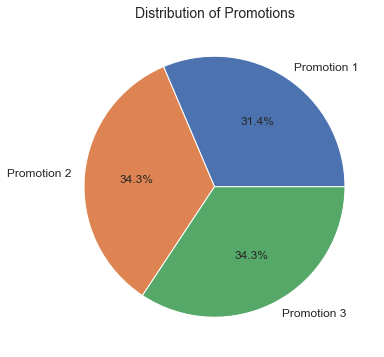

In [27]:
sns.set_theme()
plt.figure(figsize=(6,6))
pie_labels = ['Promotion 1', 'Promotion 2', 'Promotion 3']
plt.pie(df.groupby(['Promotion']).size().to_list(), 
        labels=pie_labels, autopct='%1.1f%%',textprops={'fontsize': 12})
plt.title('Distribution of Promotions', fontsize=14)
plt.show()

The distribution of each Promotion seems evenly distributed. With this in mind, we proceed to showcase histograms for each one.

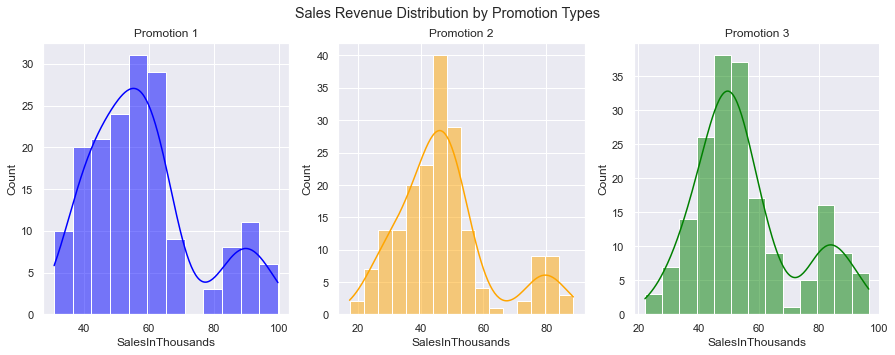

In [31]:
promo1 = df.loc[df['Promotion'] == 1]
promo2 = df.loc[df['Promotion'] == 2]
promo3 = df.loc[df['Promotion'] == 3]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(data=promo1, x="SalesInThousands", kde=True, color="blue", ax=axs[0])
sns.histplot(data=promo2, x="SalesInThousands", kde=True, color="orange", ax=axs[1])
sns.histplot(data=promo3, x="SalesInThousands", kde=True, color="green", ax=axs[2])

axs[0].set_title("Promotion 1")
axs[1].set_title("Promotion 2")
axs[2].set_title("Promotion 3")
fig.suptitle("Sales Revenue Distribution by Promotion Types")
plt.show()

In order to run parametric tests such as ANOVA to compare the distributions, we need to confirm the assumptions of normality and homogeneity of variances (independence of the examples is assumed for this experiment). The figure above hints at the possibility this might not be the case, so for the former a Shapiro-Wilk test will be used and for the latter a Levene test.

## Normality Test

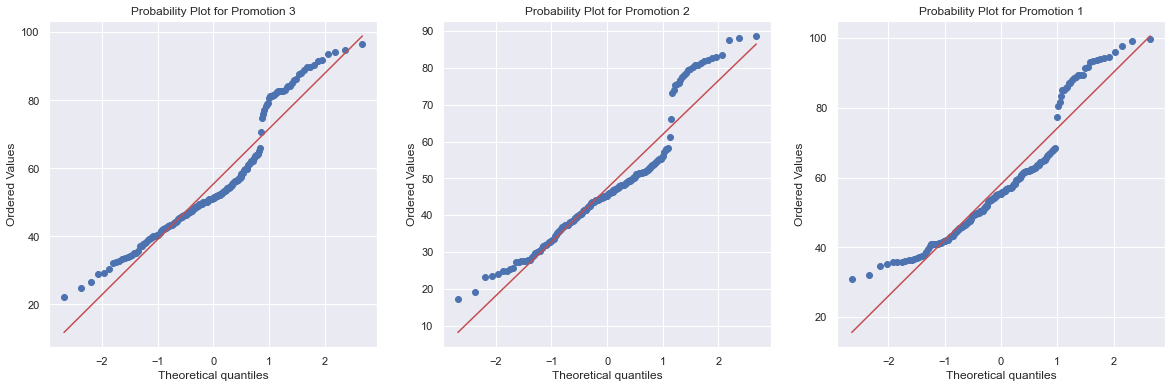

In [34]:
prom = df['Promotion'].unique()

fig,axs = plt.subplots(1,3,figsize=(20,6))

for aux,axs in zip(prom,axs):
    stats.probplot(df[df['Promotion'] == aux]['SalesInThousands'], dist="norm", plot=axs)
    axs.set_title('Probability Plot for Promotion '+ str(aux))
    axs.grid(True)

QQplots of the three promotions indicate that they are rather a bimodal distribution than a normal one.

##### Hypothesis :

Null Hypothesis: Variance of Sales are of normal distribution.

Alternative Hypothesis : Variance of Sales don't follow a normal distribution.

In [42]:
normtest1=stats.shapiro(##### Hypothesis :

Null Hypothesis: Variance of Sales revenue is equal among groups.

Alternative Hypothesis : Variance of Sales are different among groups.) 
normtest2=stats.shapiro(df[df['Promotion'] ==2]['SalesInThousands']) 
normtest3=stats.shapiro(df[df['Promotion'] ==3]['SalesInThousands']) 
print('Promo 1=',normtest1,'\n','Promo 2=',normtest2,'\n', 'Promo 3=',normtest3)

Promo 1= ShapiroResult(statistic=0.9153000712394714, pvalue=1.9773297665892642e-08) 
 Promo 2= ShapiroResult(statistic=0.9145088791847229, pvalue=5.456262108793908e-09) 
 Promo 3= ShapiroResult(statistic=0.9207685589790344, pvalue=1.499518376135711e-08)


For all three distributions the test of normality fails.

## Homogeneity of Variances Test

##### Hypothesis :

Null Hypothesis: Variance of Sales revenue is equal among groups.

Alternative Hypothesis : Variance of Sales are different among groups.

In [54]:
vartest=pg.homoscedasticity(df, dv='SalesInThousands', group='Promotion')
print(vartest)

               W      pval  equal_var
levene  1.269679  0.281751       True


The null hypothesis is not rejected, however, we cant run ANOVA due to the reject of normality. \
Instead, we employ a Mann–Whitney U test for each pair.\
This is because Promotion 1 has less samples than Promotion 2 and 3, and this inbalance of samples forbid the use of Wilcoxon test without throwing away examples.

## Comparison of Promotions

##### Hypothesis :

Null Hypothesis :Sales revenue between at least two promotion types are equal.

Alternative Hypothesis : Sales revenue of one promotion is bigger.

In [139]:
mw_stat, mw_p_value = mannwhitneyu(df[df['Promotion'] ==1]['SalesInThousands'],\
                                   df[df['Promotion'] ==2]['SalesInThousands'],\
                                  alternative='greater')
print('p value for promotion 1 and 2=', mw_p_value)

p value for promotion 1 and 2= 2.922967623419259e-12


The null hypothesis is rejected, there is a significant difference between promotions 1 and 2.

In [148]:
mw_stat, mw_p_value = mannwhitneyu(df[df['Promotion'] ==3]['SalesInThousands'],\
                                   df[df['Promotion'] ==2]['SalesInThousands'],\
                                   alternative='greater')

print('p value for promotion 2 and 3=', mw_p_value)

p value for promotion 2 and 3= 5.985042220825902e-08


The null hypothesis is rejected, there is a significant difference between promotions 2 and 3

In [145]:
mw_stat, mw_p_value = mannwhitneyu(df[df['Promotion'] ==1]['SalesInThousands'],\
                                   df[df['Promotion'] ==3]['SalesInThousands'],\
                                     alternative='greater')
print('p value for promotion 1 and 3=', mw_p_value)

p value for promotion 1 and 3= 0.017542047846615602


The null hypothesis is rejected, there is a significant difference between promotions 1 and 3

## Conclusion

The answer to the client is that the promotion # 1 is the best promotion and should be considered.\
Promotion # 2 was less effective than promotion # 1 and promotion # 3.\
Lastly, promotion # 3 isn't as effective as promotion # 1.\
Further analysis could be done by grouping the AgeOfStore or MarketSize, where further differences between the promotions could be exploited.